<a href="https://colab.research.google.com/github/lahirumanulanka/ann-visual-emotion/blob/new-dataset/notebooks/emo_CNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [155]:
from pathlib import Path
import pandas as pd, json

print("CSV locations:\n", CSV_TRAIN, "\n", CSV_VAL, "\n", CSV_TEST)

# Load map used by training
with open(LABEL_MAP) as f:
    label_to_idx_from_map = json.load(f)
print("label_map.json:", label_to_idx_from_map)

def inspect_csv(csv_path):
    df = pd.read_csv(csv_path)
    print(f"\n== {csv_path.name} ==")
    print("Rows:", len(df), "Cols:", list(df.columns))
    print(df.head(3)[["filepath","label","label_id"]])
    # Check consistency of label -> label_id
    if "label_id" in df.columns:
        bad = df[ df["label"].map(label_to_idx_from_map).fillna(-999) != df["label_id"] ]
        print("Mismatched rows (label string vs label_id):", len(bad))
        if len(bad) > 0:
            print(bad.head(5))
    print("Unique label_ids:", sorted(df["label_id"].dropna().unique().tolist()) if "label_id" in df.columns else "N/A")
    print("Unique labels:", sorted(df["label"].unique().tolist()))

inspect_csv(CSV_TRAIN)
inspect_csv(CSV_VAL)
if CSV_TEST.exists(): inspect_csv(CSV_TEST)

CSV locations:
 /content/ann-visual-emotion/data/processed/EmoSet_splits/train.csv 
 /content/ann-visual-emotion/data/processed/EmoSet_splits/val.csv 
 /content/ann-visual-emotion/data/processed/EmoSet_splits/test.csv
label_map.json: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}

== train.csv ==
Rows: 28821 Cols: ['filepath', 'label', 'label_id', 'split']
                filepath  label  label_id
0  train/angry/14147.jpg  angry         0
1  train/angry/24084.jpg  angry         0
2    train/angry/823.jpg  angry         0
Mismatched rows (label string vs label_id): 0
Unique label_ids: [0, 1, 2, 3, 4, 5, 6]
Unique labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

== val.csv ==
Rows: 5653 Cols: ['filepath', 'label', 'label_id', 'split']
                     filepath  label  label_id
0  validation/angry/10336.jpg  angry         0
1   validation/angry/3913.jpg  angry         0
2  validation/angry/23780.jpg  angry         0

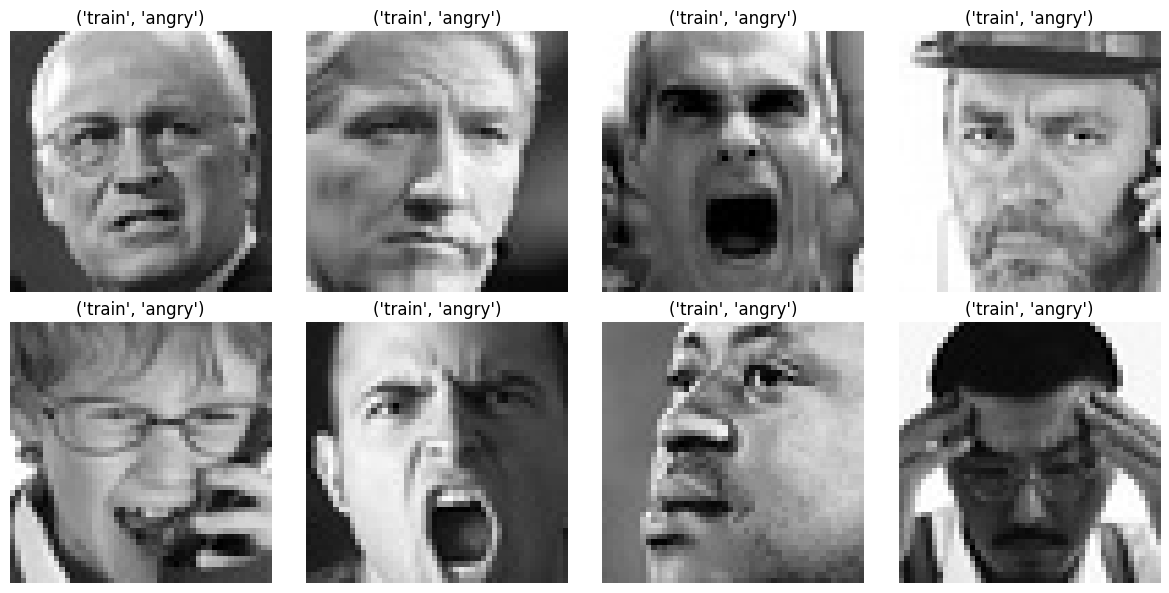

Batch shape: torch.Size([128, 1, 48, 48]) labels shape: torch.Size([128])
Tensor stats -> min: -2.3763227462768555 max: 2.314833164215088 mean: 0.02664245292544365 std: 1.2445772886276245
Label distribution in this batch: [128   0   0   0   0   0   0]


In [156]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Use your eval_tfms (normalization included). If you added Normalize, keep it; we’ll invert it to show images.
mean48, std48 = 0.5, 0.5  # replace with the values you computed if different
if 'mean48' in globals(): mean48 = mean48
if 'std48' in globals():  std48 = std48

inv_norm = transforms.Normalize(mean=[-mean48/std48], std=[1.0/std48])

# Peek a few absolute paths from the CSV and plot transformed tensors
df = pd.read_csv(CSV_TRAIN)
paths = df["filepath"].tolist()[:8]

def resolve(p): return (DATA_ROOT/Path(p)).resolve()

plt.figure(figsize=(12,6))
shown = 0
for p in paths:
    ap = resolve(p)
    if ap.exists():
        img = Image.open(ap).convert("L")
        t = eval_tfms(img)  # transformed tensor (1,48,48)
        t_show = inv_norm(t)  # roughly undo normalization for display
        shown += 1
        plt.subplot(2,4,shown)
        plt.imshow(t_show.squeeze().numpy(), cmap="gray")
        plt.title(Path(p).parts[:2])
        plt.axis('off')
        if shown == 8: break
plt.tight_layout(); plt.show()

# Also check raw stats of a minibatch
xb, yb = next(iter(val_ld))
print("Batch shape:", xb.shape, "labels shape:", yb.shape)
print("Tensor stats -> min:", xb.min().item(), "max:", xb.max().item(), "mean:", xb.mean().item(), "std:", xb.std().item())
print("Label distribution in this batch:", np.bincount(yb.numpy(), minlength=len(idx_to_label)))

In [157]:
# Run one pass on val and see distribution of predictions
model.eval()
preds = []
trues = []
with torch.no_grad():
    for xb, yb in val_ld:
        xb = xb.to(device)
        out = model(xb)
        preds += out.argmax(1).cpu().tolist()
        trues += yb.tolist()

import numpy as np
print("Pred count per class:", np.bincount(preds, minlength=len(idx_to_label)))
print("True  count per class:", np.bincount(trues, minlength=len(idx_to_label)))

Pred count per class: [   0 5653    0    0    0    0    0]
True  count per class: [ 768   89  814 1460  973  911  638]


In [158]:
from torch.utils.data import Subset

subset_idx = np.random.choice(len(train_ds), size=min(128, len(train_ds)), replace=False)
tiny_ds = Subset(train_ds, subset_idx)
tiny_ld = DataLoader(tiny_ds, batch_size=32, shuffle=True)

tmp_model = EmoCNN_SE(num_classes).to(device)
opt = torch.optim.Adam(tmp_model.parameters(), lr=1e-3)
ce  = nn.CrossEntropyLoss()

for ep in range(1, 11):
    tmp_model.train(); losses=[]
    for xb, yb in tiny_ld:
        xb, yb = xb.to(device), yb.to(device)
        out = tmp_model(xb)
        loss = ce(out, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        losses.append(loss.item())
    print(f"tiny overfit ep{ep}: loss {np.mean(losses):.4f}")

tiny overfit ep1: loss 1.9603
tiny overfit ep2: loss 1.8263
tiny overfit ep3: loss 1.7319
tiny overfit ep4: loss 1.7173
tiny overfit ep5: loss 1.6803
tiny overfit ep6: loss 1.6684
tiny overfit ep7: loss 1.7069
tiny overfit ep8: loss 1.6290
tiny overfit ep9: loss 1.6268
tiny overfit ep10: loss 1.5865


In [159]:
class CSVImageDataset(Dataset):
    """Reads filepath,label,label_id from CSV. Uses label_id if present (safer)."""
    def __init__(self, csv_path: Path, data_root: Path, img_mode='L', transform=None, verbose=True):
        self.df = pd.read_csv(csv_path)
        self.data_root = Path(data_root)
        self.img_mode  = img_mode.upper()
        self.transform = transform

        keep, miss = [], []
        for r in self.df.to_dict("records"):
            ap = smart_resolve(str(r["filepath"]), self.data_root)
            if ap and ap.exists():
                r["_abs_path"] = ap
                # prefer label_id; else map with label_map we read outside
                if "label_id" in r and not pd.isna(r["label_id"]):
                    r["_y"] = int(r["label_id"])
                else:
                    # fallback to string label via global label_to_idx
                    r["_y"] = label_to_idx[r["label"]]
                keep.append(r)
            else:
                miss.append(r["filepath"])
        self.rows = keep
        if verbose:
            print(f"[{csv_path.name}] kept {len(keep)}  missing {len(miss)}")
            if miss[:3]: print("  e.g. missing:", miss[:3])

    def __len__(self): return len(self.rows)

    def __getitem__(self, i):
        r = self.rows[i]
        with Image.open(r["_abs_path"]) as im:
            im = im.convert("RGB") if self.img_mode=="RGB" else im.convert("L")
            x = self.transform(im) if self.transform else transforms.ToTensor()(im)
        y = r["_y"]
        return x, y

In [160]:
with open(LABEL_MAP) as f:
    label_to_idx = json.load(f)
idx_to_label = {i: lbl for lbl, i in label_to_idx.items()}
num_classes  = len(idx_to_label)
print("Labels:", idx_to_label)

with open(STATS_JSON) as f:
    stats = json.load(f)
train_counts = stats["splits"]["train"]["by_label"]
cw = np.zeros(num_classes, dtype=np.float32)
for lbl, idx in label_to_idx.items():
    c = max(1, train_counts.get(lbl, 1))
    cw[idx] = 1.0 / np.log1p(c)           # smooth inverse frequency
cw = cw * (len(cw) / cw.sum())
class_weights = torch.tensor(cw, dtype=torch.float32)

Labels: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [161]:
probe_tfms = transforms.Compose([transforms.Resize((48,48)), transforms.ToTensor()])
train_probe = CSVImageDataset(CSV_TRAIN, DATA_ROOT, "L", probe_tfms, verbose=False)

def compute_mean_std(ds, max_samples=5000):
    n = min(len(ds), max_samples)
    if n == 0: return 0.5, 0.5
    idxs = np.random.choice(len(ds), n, replace=False)
    s = 0.0; s2 = 0.0; count = 0
    for i in idxs:
        x, _ = ds[i]                  # x: (1,48,48) in [0,1]
        v = x.view(-1)
        s  += v.mean().item()
        s2 += v.std().item()
        count += 1
    m = s / count
    sd = s2 / count
    return float(m), float(sd)

mean48, std48 = compute_mean_std(train_probe)
print(f"Train mean/std (approx): {mean48:.4f} / {std48:.4f}")

Train mean/std (approx): 0.5111 / 0.2118


In [162]:
def ema_update(model, ema_model, decay=0.999):
    with torch.no_grad():
        msd = model.state_dict()
        for k in ema_model.state_dict().keys():
            ema_model.state_dict()[k].mul_(decay).add_(msd[k]*(1.0-decay))

def mixup(x, y, alpha=0.2):
    if alpha <= 0 or x.size(0) < 2: return x, (y,y,None), None
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    return lam*x + (1-lam)*x[idx], (y, y[idx], lam), lam

def cutmix(x, y, alpha=0.2):
    if alpha <= 0 or x.size(0) < 2: return x, (y,y,None), None
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    B, C, H, W = x.size()
    cx, cy = np.random.randint(W), np.random.randint(H)
    w = int(W * math.sqrt(1-lam)); h = int(H * math.sqrt(1-lam))
    x1 = np.clip(cx - w//2, 0, W); y1 = np.clip(cy - h//2, 0, H)
    x2 = np.clip(cx + w//2, 0, W); y2 = np.clip(cy + h//2, 0, H)
    x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
    lam_adj = 1 - ((x2-x1)*(y2-y1)/(W*H))
    return x, (y, y[idx], lam_adj), lam_adj

def criterion_mix(crit, pred, target):
    y1, y2, lam = target
    if lam is None: return crit(pred, y1)
    return lam*crit(pred, y1) + (1-lam)*crit(pred, y2)

In [163]:
class SE(nn.Module):
    def __init__(self, ch, r=8):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(ch, max(4, ch//r)), nn.ReLU(True),
            nn.Linear(max(4, ch//r), ch), nn.Sigmoid()
        )
    def forward(self, x):
        w = self.fc(x).unsqueeze(-1).unsqueeze(-1)
        return x * w

class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False), nn.BatchNorm2d(out_ch)
        )
        self.proj = nn.Conv2d(in_ch, out_ch, 1, bias=False) if in_ch!=out_ch else nn.Identity()
        self.act = nn.ReLU(True); self.se = SE(out_ch)
    def forward(self, x):
        y = self.conv(x) + self.proj(x)
        return self.act(self.se(y))

class EmoCNN_SE(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1,bias=False), nn.BatchNorm2d(32), nn.ReLU(True)
        )
        self.b1 = Block(32, 64);  self.pool1 = nn.MaxPool2d(2)   # 48->24
        self.b2 = Block(64, 128); self.pool2 = nn.MaxPool2d(2)   # 24->12
        self.b3 = Block(128,128); self.pool3 = nn.MaxPool2d(2)   # 12->6
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Dropout(0.35),
            nn.Linear(128, 128), nn.ReLU(True),
            nn.Dropout(0.35),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.stem(x)
        x = self.pool1(self.b1(x))
        x = self.pool2(self.b2(x))
        x = self.pool3(self.b3(x))
        return self.head(x)

model = EmoCNN_SE(num_classes).to(device)

In [ ]:
# 1) Rebuild loaders: weighted sampler + simple augment + normalization
from torchvision import transforms
from torch.utils.data import WeightedRandomSampler, DataLoader

train_tfms = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(8),
    transforms.ToTensor(),
    transforms.Normalize((mean48,), (std48,))
])
eval_tfms = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize((mean48,), (std48,))
])

train_ds = CSVImageDataset(CSV_TRAIN, DATA_ROOT, "L", train_tfms)
val_ds   = CSVImageDataset(CSV_VAL,   DATA_ROOT, "L", eval_tfms)
test_ds  = CSVImageDataset(CSV_TEST,  DATA_ROOT, "L", eval_tfms) if CSV_TEST.exists() else None

sample_w = []
for _, y in CSVImageDataset(CSV_TRAIN, DATA_ROOT, "L", transforms.ToTensor(), verbose=False):
    sample_w.append(class_weights[y].item())
sampler = WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)

train_ld = DataLoader(train_ds, batch_size=128, shuffle=False, sampler=sampler, num_workers=2, pin_memory=True)
val_ld   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
test_ld  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=2, pin_memory=True) if test_ds else None

# 2) Fresh model (no EMA)
baseline = EmoCNN_SE(num_classes).to(device)
crit = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.02)  # smaller smoothing
opt  = torch.optim.AdamW(baseline.parameters(), lr=1e-3, weight_decay=1e-4)
# Remove verbose=True as it's not a valid argument
sched= torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=2)  # on F1

# 3) Train for 20 epochs max, early stop on val F1
best_f1, best_state = 0.0, None
for ep in range(1, 21):
    baseline.train()
    for xb, yb in train_ld:
        xb, yb = xb.to(device), yb.to(device)
        out = baseline(xb)
        loss = crit(out, yb)
        opt.zero_grad(); loss.backward(); opt.step()

    # validate
    baseline.eval(); yt=[]; yp=[]
    with torch.no_grad():
        for xb, yb in val_ld:
            xb = xb.to(device)
            out = baseline(xb)
            yp += out.argmax(1).cpu().tolist(); yt += yb.tolist()
    va_f1 = f1_score(yt, yp, average="macro"); va_acc = accuracy_score(yt, yp)
    print(f"Baseline ep{ep:02d} | val F1 {va_f1:.3f} acc {va_acc:.3f}")
    sched.step(va_f1)

    if va_f1 > best_f1:
        best_f1 = va_f1
        best_state = baseline.state_dict().copy()

# 4) Test (if exists)
if best_state is not None: baseline.load_state_dict(best_state)
if test_ld and best_state is not None:
    baseline.eval(); yt=[]; yp=[]
    with torch.no_grad():
        for xb, yb in test_ld:
            xb = xb.to(device)
            yp += baseline(xb).argmax(1).cpu().tolist(); yt += yb.tolist()
    print("\nTEST report:\n", classification_report(yt, yp, target_names=[idx_to_label[i] for i in range(num_classes)]))

[train.csv] kept 28821  missing 0
[val.csv] kept 5653  missing 0
[test.csv] kept 1413  missing 0
Baseline ep01 | val F1 0.210 acc 0.359
Baseline ep02 | val F1 0.381 acc 0.460
Baseline ep03 | val F1 0.395 acc 0.521
